# Раздел 1. Модель

In [2]:
# импорт библиотек

# работа с директориями
from glob import glob # поиск файлов по шаблону
import os
import shutil

# визуализация данных
import matplotlib.pyplot as plt
import pandas as pd

# работа с изображениями
import PIL
from PIL import Image
import torchvision.models as models # модели для работы с изображениями
import torchvision.transforms as transforms # преобразование изображений

# для jupyter notebook
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm # прогресс-бар

# numpy
import numpy as np

# scikit-learn
from sklearn.model_selection import GroupKFold # кросс-валидация
from sklearn.metrics import roc_curve #
from sklearn import metrics #

# pytorch
import torch
import torch.nn as nn # разные слои
import torch.nn.functional as F # функции активации
import torch.nn.init as init # начальная инициализация весов в слоях
from torch.utils.data import Dataset # датасет поместим в объект dataset
from torch.utils.data import DataLoader # это объект разбиения на батчи
from torch.utils.data import random_split
from torchsummary import summary # просмотр архитектуры нейросети

# остальное
import itertools
import random
import time

# комментарии надо дописать

## 1. Постановка задачи

Будем обучать нейросеть, которая должна будет изображения перерисовывать в стиле картин Моне, это задача с kaggle.com - [ссылка](https://www.kaggle.com/competitions/gan-getting-started), данные для обучения скачал оттуда:

- `monet_jpg` - папка с 300 jpg-изображениями картин Моне размера 256x256
- `photo_jpg` - папка с 7038 jpg-изображениями размера 256x256
- `monet_tfrec` и `photo_jpg` - удалил, так как решил работать с .jpg форматом

Использовать для этого будем библиотеку `PyTorch`, поэтому как итог раздела определим на чем будут производиться вычисления - библиотека поддерживает вычисления как на обычном процессоре, так и на графическом.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Импорт данных (предварительно упаковав их в интерфейс `Dataset` библиотеки `PyTorch`)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256)):
        super().__init__()
        self.monet_dir = monet_dir # это путь к картинам Моне в формате .jpg
        self.photo_dir = photo_dir # это путь к обычным изображениям в том же формате
        self.monet_idx = dict()    # тут будут храниться имена файлов
        self.photo_idx = dict()    # аналогично
        self.transform = transforms.Compose([
            transforms.Resize(size), # приводим к определенному размеру
            transforms.ToTensor(),   # создаем из изображение PyTorch tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # каналы [0, 1] -> [-1, 1]                               
        ])
        # not f.startswith('.') для того чтобы исключить папку .ipynb_checkpoints
        for i, fl in enumerate([f for f in os.listdir(self.monet_dir) if not f.startswith('.')]):
            self.monet_idx[i] = fl
        for i, fl in enumerate([f for f in os.listdir(self.photo_dir) if not f.startswith('.')]):
            self.photo_idx[i] = fl

    def __getitem__(self, idx): # вместе с картиной Моне извлекаем случайное обычное изображение
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return monet_img, photo_img

    def __len__(self):
        return len(self.monet_idx.keys())

In [5]:
img_ds = ImageDataset('monet_jpg/', 'photo_jpg/')

Давайте посмотрим на примеры загруженных данных.

In [6]:
# это обратное преобразование [-1, 1] -> [0, 1] для визуализации (такие данные принимает plt.imshow)
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
    return img

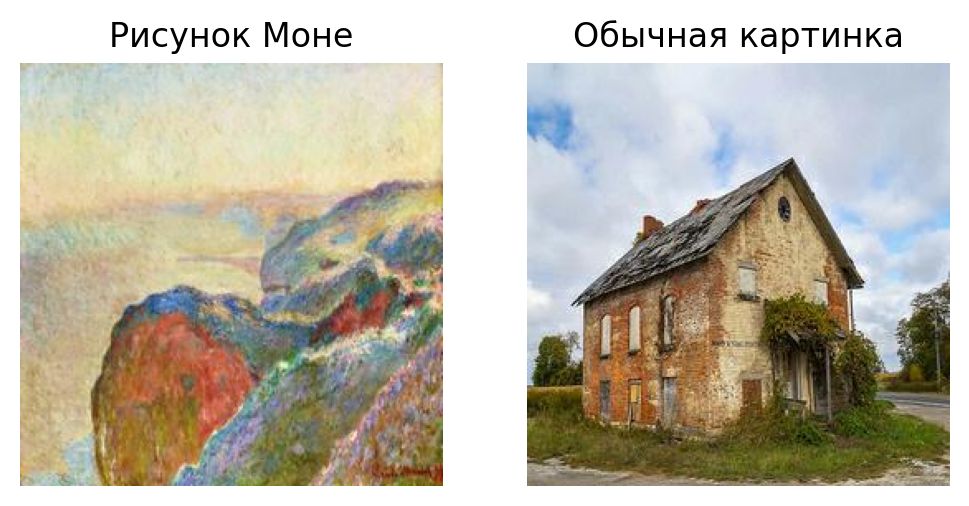

In [7]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True) # разбиение на батчи
monet_img, photo_img = next(iter(img_dl)) # извлекаю 1 батч

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), dpi=200)

ax[0].axis('off')
ax[0].set_title('Рисунок Моне')
monet_img = unnorm(monet_img)
ax[0].imshow(monet_img[0].permute(1, 2, 0)) # tensor имеет shape = (channel, width, height)
                                            # переводим его в shape = (width, height, channel) для .imshow
ax[1].axis('off')
ax[1].set_title('Обычная картинка')
photo_img = unnorm(photo_img)
ax[1].imshow(photo_img[0].permute(1, 2, 0));

## 3. Разработка модели

Решение задачи будет осуществляться с помощью нейросети `CycleGAN`.

**CycleGAN** (Cycle-Consistent Generative Adversarial Network) — это тип генеративной состязательной сети (GAN), предназначенный для выполнения непарного перевода изображений. В отличие от традиционных методов, которые требуют пар данных для обучения (например, пары изображений "до" и "после"), CycleGAN обучается на одном наборе изображений для каждой из двух доменов и может генерировать изображения одного домена в изображения другого домена без наличия парных данных.

Архитектура **CycleGAN** состоит из двух основных компонентов: генераторов и дискриминаторов. Она предназначена для выполнения непарного перевода изображений между двумя доменами $ X $ и $ Y $. Основная идея заключается в использовании двух генераторов и двух дискриминаторов, а также добавлении потерь циклической консистентности, чтобы преобразование изображений было обратимым. Рассмотрим архитектуру более подробно.

CycleGAN включает:
- **Два генератора**:
  - $ G_{X \to Y} $: преобразует изображения из домена $ X $ (например, лошади) в домен $ Y $ (например, зебры).
  - $ G_{Y \to X} $: преобразует изображения из домена $ Y $ обратно в домен $ X $.
  
- **Два дискриминатора**:
  - $ D_Y $: различает между реальными изображениями домена $ Y $ и изображениями, сгенерированными $ G_{X \to Y} $.
  - $ D_X $: различает между реальными изображениями домена $ X $ и изображениями, сгенерированными $ G_{Y \to X} $.

### 3.1. Архитектура генератора и дискриминатора

Для генераторов и дискриминаторов будем использовать следующие слои:

- **Слой свертки** `Conv2d`: реализует двумерную свёртку, которая используется для обработки двумерных данных; вот эти параметры будем использовать для задания этого слоя:
    - `in_channels`: количество входных каналов (слой применяет ядро свертки для каждого канала независимо, а затем складывает результаты)
    - `out_channels`: количество независимых ядер свертки, указывает количество выходных каналов;
    - `kernel_size`: размер ядра свертки;
    - `stride`: шаг перемещения ядра свертки;
    - `padding`: определяет надо ли добавлять нули по границам изображения (для сохранения размера выхода);
    - `bias`: добавлять ли обучаемое смещение.
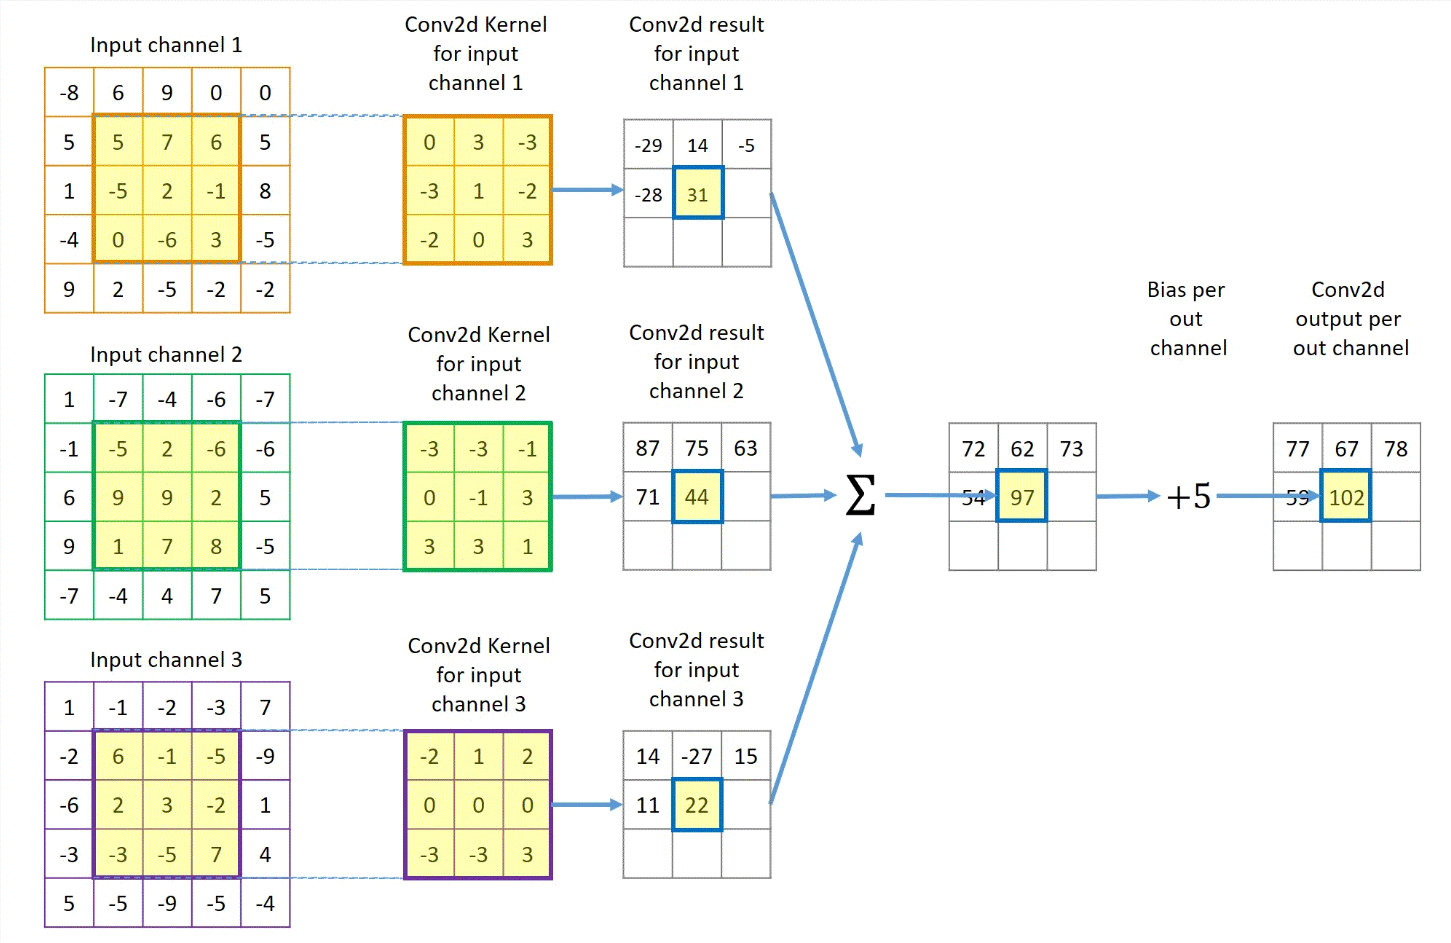
- **Слой обратной свертки** `ConvTranspose2d`: реализует свертку с увеличением размерности:
    - `in_channels`: количество входных каналов
    - `out_channels`: количество независимых ядер свертки, указывает количество выходных каналов;
    - `kernel_size`: размер ядра свертки;
    - `stride`: шаг перемещения ядра свертки;
    - `padding`: определяет сколько нулей добавлять по границам изображения;
    - `output_padding`: более тотечная настройка размера выходного изображения (реализуется тем же путем, что и `padding`).
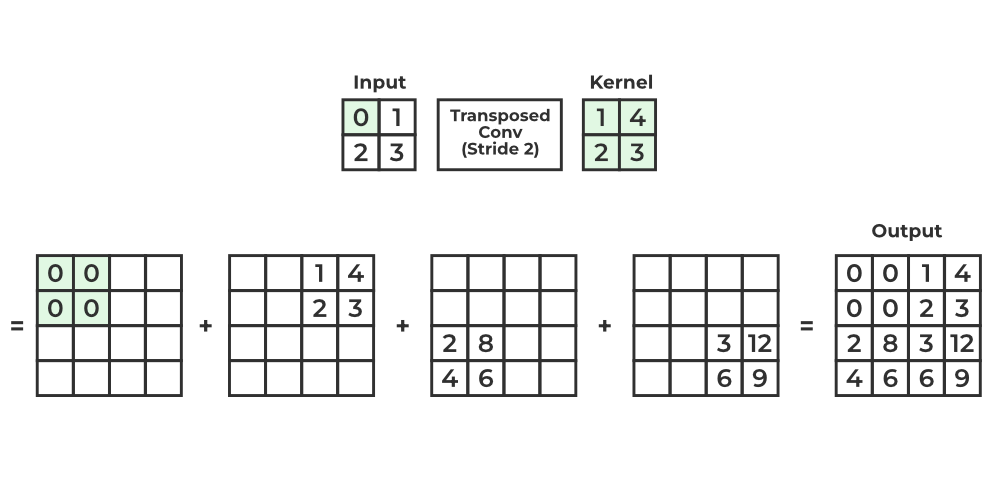
- **Слой дополнения изображения** `ReflectionPad2d` с его помощью на границах тензора зеркально отражаются его значения:
    - `padding`: размеры паддинга `(left, right, top, bottom)`.
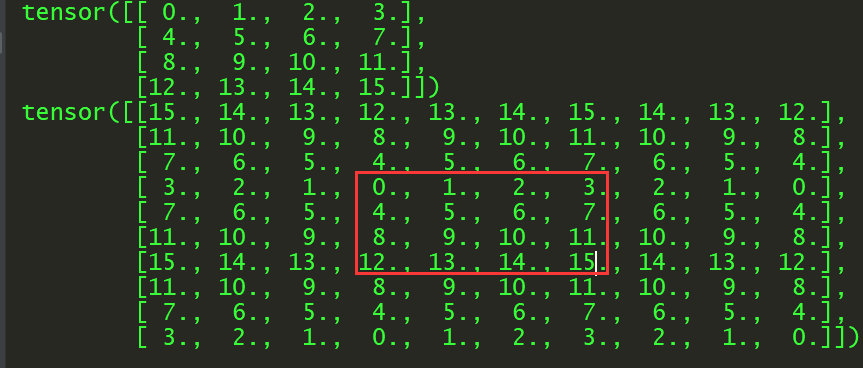
- **Слой деактивации** `Dropout`:
    - *Во время обучения* в каждом шаге обучения случайным образом выбирается подмножество нейронов в слое, которые будут "выключены", это делается с вероятностью `p`;
    - *Во время тестирования* слой не работает.
- **Слои нормализации**:
    - `BatchNorm2d`: нормализует каждый признак поотдельности независимо от канала по всему батчу:
        - `num_features`: количество каналов;
        - далее $x_{i, c}$ - $c$-й канал из $i$-го батча ($x_{i, c}\in\mathbb R^{256 \times 256}$), $m$ - размер батча;
        - $\displaystyle \mu_c = \frac{1}{m} \sum\limits_{i=1}^{m} x_{i, c}$ - среднее значение в батче;
        - $\displaystyle \sigma_c^2 = \frac{1}{m} \sum\limits_{i=1}^{m} (x_{i, c} - \mu_c)^2$ - квадрат среднеквадратического отклонения;
        - $\displaystyle \hat{x}_{i, c} = \frac{x_{i, c} - \mu_c}{\sqrt{\sigma_c^2 + \varepsilon}}$ - нормализованное значение, где $\varepsilon$ - просто какое-то маленькое значение;
        - $\displaystyle y_{i, c} = \gamma_c \hat{x}_{i, c} + \beta_c$ - выходное значение, полученное масштабированием и смещением ($\gamma_c$ и $\beta_c$ - обучаемые параметры).
    - `InstanceNorm2d`: нормализует признаки независимо от канала и батча:
        - `num_features`: количество каналов;
        - далее $x_{j, c}^i$ - $j$-й признак $c$-го канала из $i$-го батча, $n$ - размер канала;
        - $\displaystyle \mu_c^i = \frac{1}{n} \sum\limits_{j=1}^{n} x_{j, c}^i$ - среднее значение по каналу в батче;
        - $\displaystyle \sigma_c^{i2} = \frac{1}{n} \sum_{j=1}^{n} (x_{j, c}^i - \mu_c^i)^2$ - квадрат среднеквадратического отклонения;
        - $\displaystyle \hat{x}_{j, c}^i = \frac{x_{j, c}^i - \mu_c^i}{\sqrt{\sigma_c^{i2} + \varepsilon}}$ - нормализованное значение;
        - $\displaystyle y_{j, c}^i = \gamma_c \hat{x}_{j, c}^i + \beta_c$ - масштабирование и смещение (тут аналогично $\gamma_c$ и $\beta_c$ - обучаемые параметры).

А также в генераторах и дискриминаторах будем использовать следующие функции активации (оформленные в слои):

- **Leaky Rectified Linear Unit** `LeakyReLU`

$\operatorname{LeakyReLU}(x) = \left\{\begin{align*}
x, x \geq 0,
\alpha x, x < 0.
\end{align*}\right.$

- **Gaussian Error Linear Unit** `GELU`

$\operatorname{GELU}(x) = $

- **Hyperbolic Tangent** `Tanh`

$\operatorname{Tanh}(x) = $

In [8]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )

In [9]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

In [10]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

### 3.2. Архитектура CycleGAN

In [13]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [14]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [15]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [16]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [17]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

In [19]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            torch.save(self.gen_ptm, 'gen.pth')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [20]:
gan = CycleGAN(3, 3, 50, device)

### 3.3. Тренировка модели

In [21]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:11.279772 | Discriminator Loss:0.877313


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:9.940231 | Discriminator Loss:0.431097


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:9.090847 | Discriminator Loss:0.448584


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:8.644229 | Discriminator Loss:0.423468


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:8.713804 | Discriminator Loss:0.390888


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:8.447685 | Discriminator Loss:0.368136


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:8.205285 | Discriminator Loss:0.398053


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:7.690562 | Discriminator Loss:0.429996


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:7.530626 | Discriminator Loss:0.444264


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:7.516563 | Discriminator Loss:0.408314


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:7.584803 | Discriminator Loss:0.394861


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:7.373718 | Discriminator Loss:0.402931


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:7.365362 | Discriminator Loss:0.398667


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:7.060405 | Discriminator Loss:0.403828


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:7.360144 | Discriminator Loss:0.399369


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:7.173458 | Discriminator Loss:0.385748


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:7.222362 | Discriminator Loss:0.385121


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:7.061305 | Discriminator Loss:0.373812


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:6.946147 | Discriminator Loss:0.378106


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:7.151007 | Discriminator Loss:0.366886


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:7.038543 | Discriminator Loss:0.354691


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:7.026462 | Discriminator Loss:0.358228


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:6.905311 | Discriminator Loss:0.373654


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:6.747593 | Discriminator Loss:0.344253


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:6.929563 | Discriminator Loss:0.359517


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:6.994703 | Discriminator Loss:0.350480


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:6.697628 | Discriminator Loss:0.343451


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:6.638590 | Discriminator Loss:0.326676


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:6.561408 | Discriminator Loss:0.312633


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:6.699247 | Discriminator Loss:0.320896


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:6.541317 | Discriminator Loss:0.312756


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:6.467499 | Discriminator Loss:0.295382


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:6.484444 | Discriminator Loss:0.285197


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:6.388741 | Discriminator Loss:0.295886


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:6.403863 | Discriminator Loss:0.282205


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:6.435193 | Discriminator Loss:0.275171


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:6.201009 | Discriminator Loss:0.280508


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:6.286076 | Discriminator Loss:0.255811


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:6.192551 | Discriminator Loss:0.258590


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:6.184212 | Discriminator Loss:0.250175


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:6.051057 | Discriminator Loss:0.239412


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:6.078433 | Discriminator Loss:0.230331


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:6.046783 | Discriminator Loss:0.212757


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:5.951039 | Discriminator Loss:0.216953


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:5.968827 | Discriminator Loss:0.206195


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:5.955065 | Discriminator Loss:0.200182


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:5.943581 | Discriminator Loss:0.200567


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:5.922161 | Discriminator Loss:0.172793


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:5.943591 | Discriminator Loss:0.166984


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:5.928463 | Discriminator Loss:0.168710


In [43]:
torch.save(gan.gen_ptm.state_dict(), 'model.pth')

In [44]:
gen = Generator(3, 3)
gen.load_state_dict(torch.load('model.pth'))

C:\Users\nikvo\AppData\Local\Temp\ipykernel_2880\1633994837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

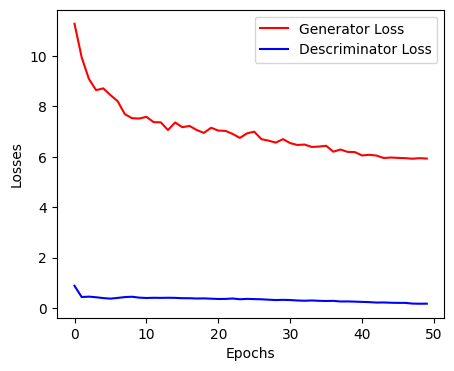

In [42]:
plt.figure(figsize=(5, 4), dpi=100)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

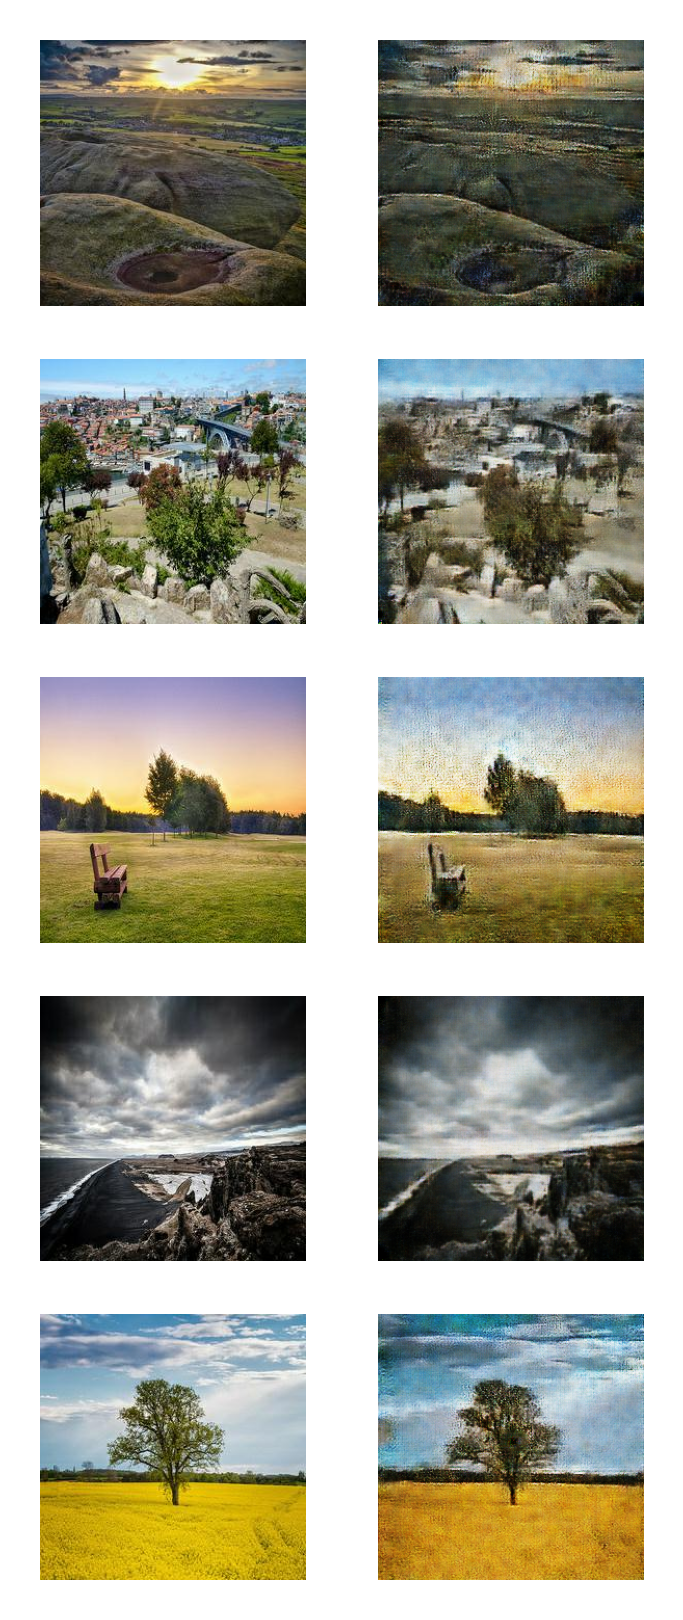

In [46]:
_, ax = plt.subplots(5, 2, figsize=(2, 5), dpi=400)
for i in range(5):
    _, photo_img = next(iter(img_dl))
    pred_monet = gen(photo_img).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()